# Прогнозирование уровня средней заработной платы в России

## Импорт необходимых библиотек

In [63]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product as prd

def inv_box_cox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/maria/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Чтение и знакомство с данными

In [50]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [51]:
data.columns = ['wage']

In [52]:
data.head()

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [53]:
data.describe()

,wage
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


## Визуальный анализ ряда

Строим график временного ряда

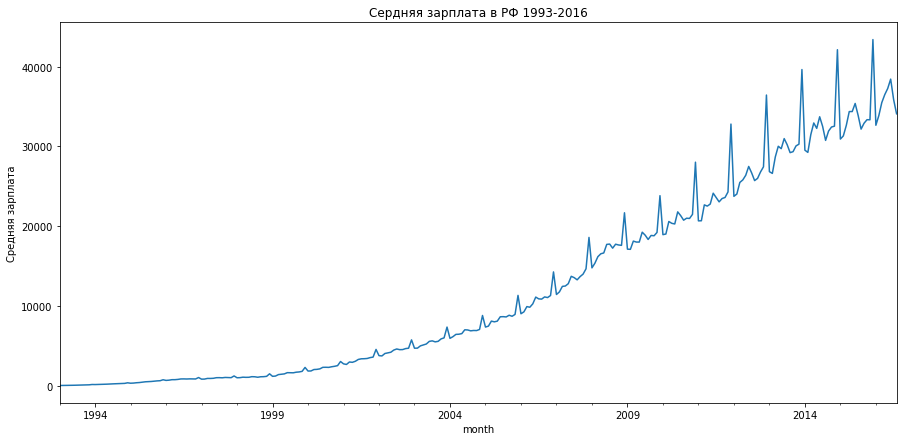

In [55]:
plt.figure(figsize(15,7))
data.wage.plot()
plt.ylabel(u"Средняя зарплата")
plt.title(u"Сердняя зарплата в РФ 1993-2016")
pylab.show()

STL-декомпозиция

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

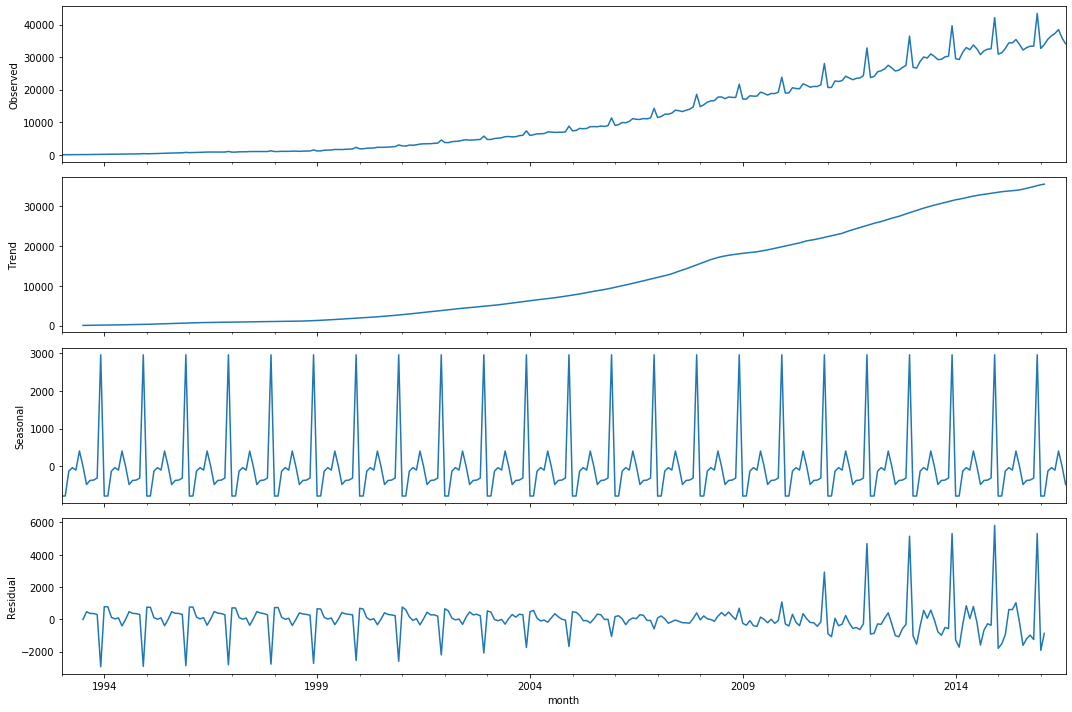

In [56]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage)[1])

Так как уровень значимости критерия Дики Фуллера выше 0.05, мы не можем принять гипотезу о стационарности временного ряда.

## Стабилизация дисперсии 

Применим преобразование Бокса-Кокса:

Параметр преобразования Бокса-Кокса: 0.263202
Дики-Фуллера: p=0.696899


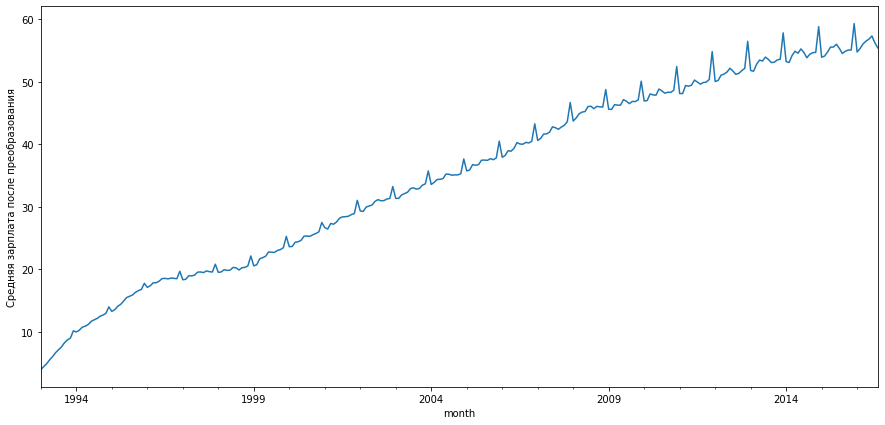

In [57]:
data['wage_box'], lymbda = stats.boxcox(data.wage)
plt.figure(figsize(15,7))
data.wage_box.plot()
plt.ylabel(u'Средняя зарплата после преобразования')
print("Параметр преобразования Бокса-Кокса: %f" % lymbda)
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

## Выбор порядка дифференцирования 

Сезонное дифференцирование:

Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

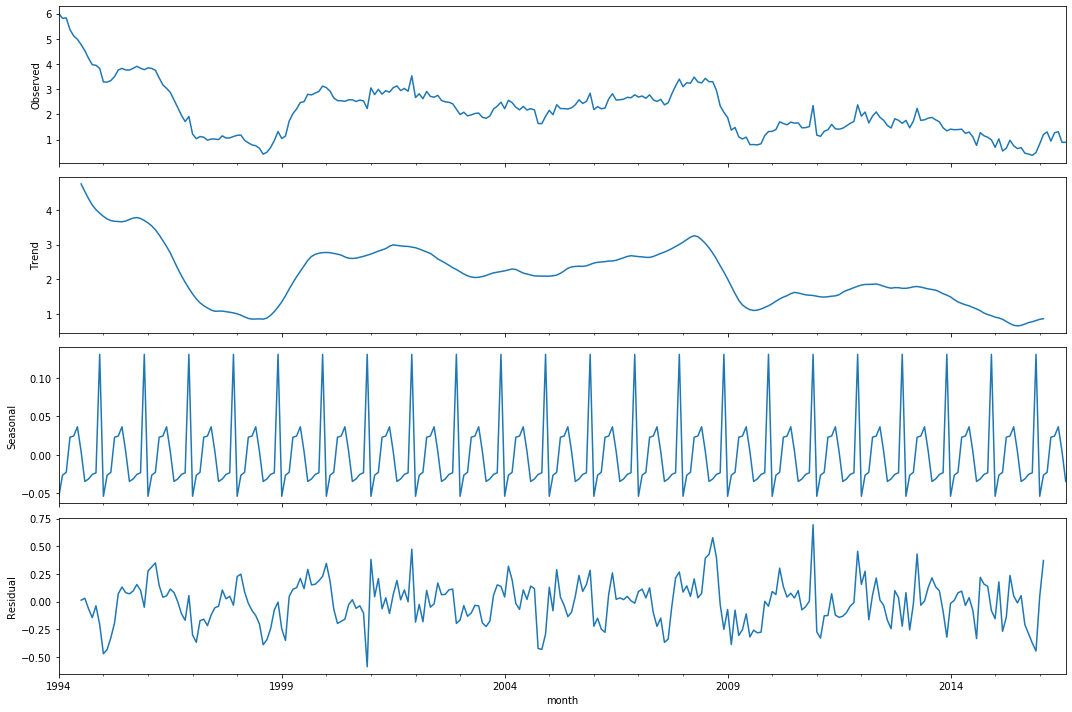

In [58]:
data['wage_box_diff'] = data.wage_box - data.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff[12:]).plot()
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff[12:])[1])

Обычное дифференцирование:

Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

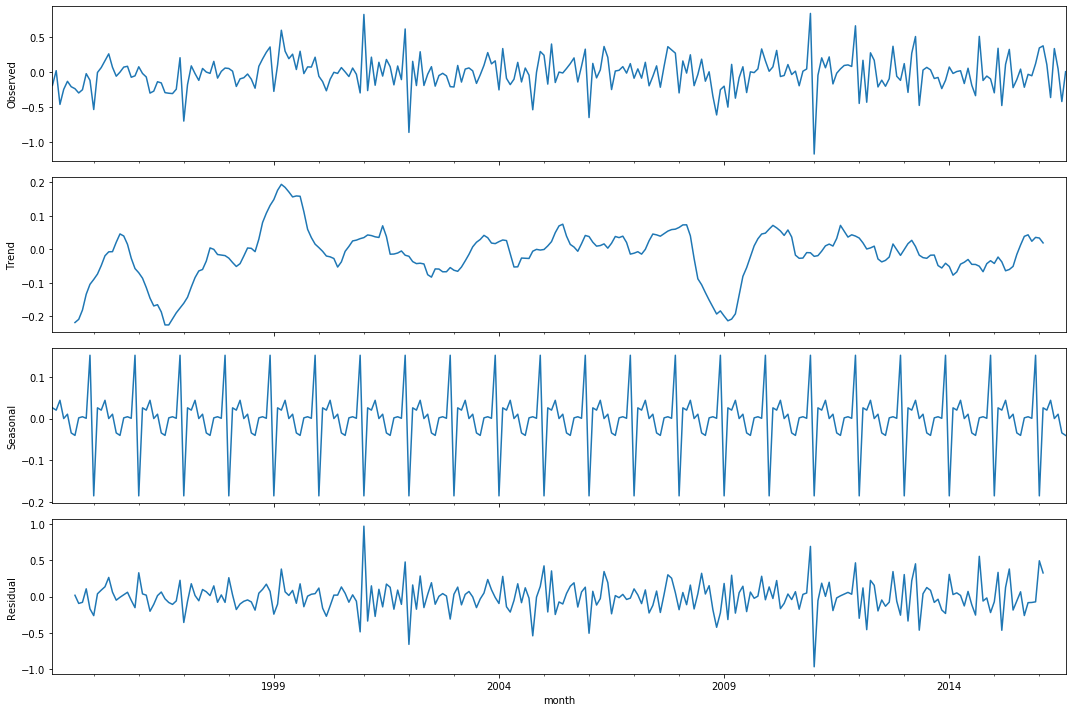

In [59]:
data['wage_box_diff2'] = data.wage_box_diff - data.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box_diff2[13:]).plot()
print("Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box_diff2[13:])[1])

Получен стационарный временной ряд

## Выбор начальных приближений для p, q, P, Q

Графики автокорреляции:

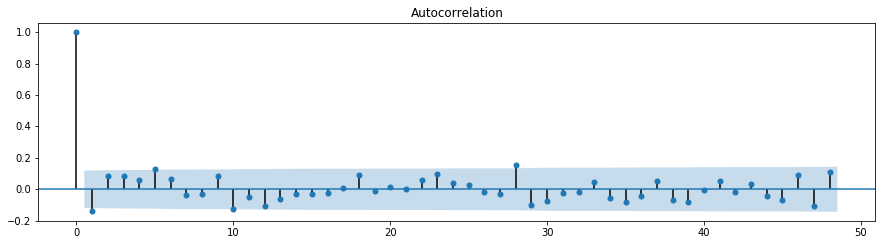

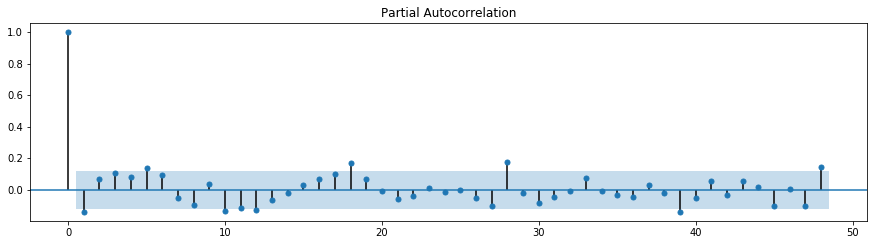

In [60]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Подходящие начальные приближения: Q=0, q=1, P=1, p=1.

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [61]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [66]:
parameters = prd(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("длина массива параметров: "+str(len(parameters_list)))

длина массива параметров: 8


In [67]:
results = []
better_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < better_aic:
        better_model = model
        better_aic = aic
        better_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print('______________________')
print('\n')
print('better model: ')
print(better_model.summary())

     parameters       aic
5  (1, 0, 1, 0)  0.340521
3  (0, 1, 1, 0)  1.170768
7  (1, 1, 1, 0)  2.021911
4  (1, 0, 0, 0)  2.625709
2  (0, 1, 0, 0)  3.369832
______________________


better model: 
                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Fri, 16 Apr 2021   AIC                              0.341
Time:                                    21:59:46   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.

График автокорреляции

Критерий Стьюдента: 0.090793
Критерий Дики-Фуллера: 0.000003


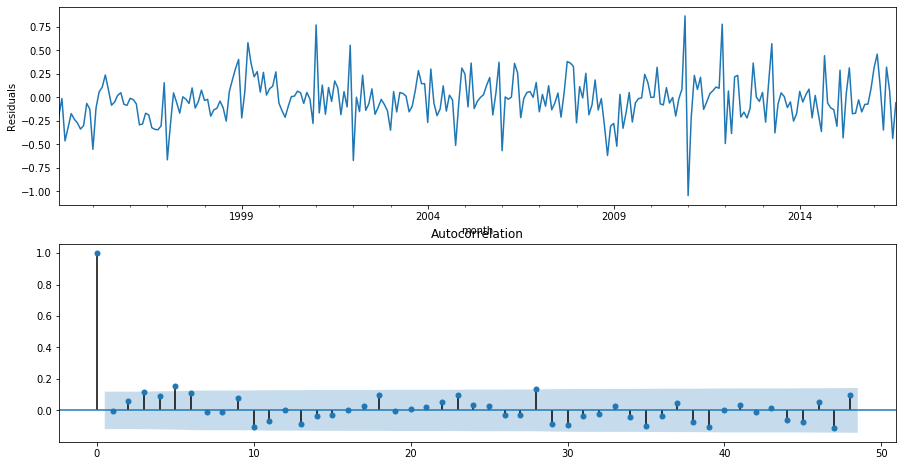

In [68]:
plt.figure(figsize(15,8))
plt.subplot(211)
better_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(better_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: %f" % stats.ttest_1samp(better_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: %f" % sm.tsa.stattools.adfuller(better_model.resid[13:])[1])

Критерий Стъюдента подтвеждает несмещенность остатков, критерий Дики-Фуллера подтверждает их стационарность, критерий Льюнга-Бокса и коррелограмма подверждают, что остатки неавтокоррелированы.

График по модели

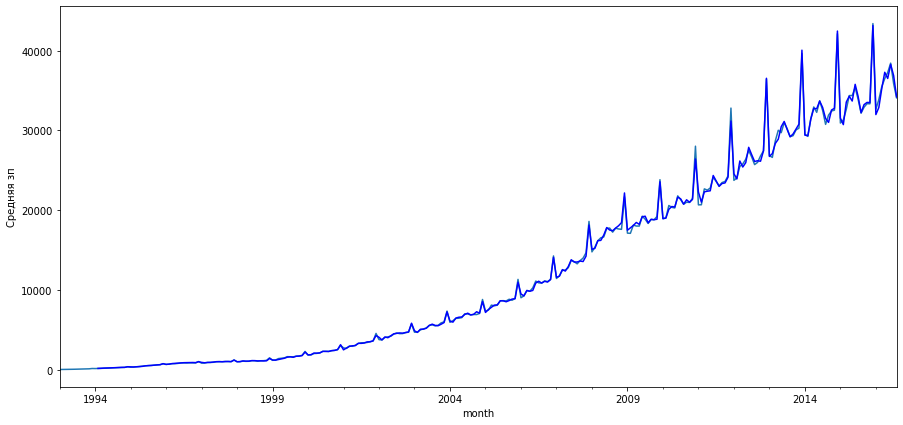

In [74]:
data['model'] = inv_box_cox(better_model.fittedvalues, lymbda)
plt.figure(figsize(15,7))
data.wage.plot()
data.model[13:].plot(color='b')
plt.ylabel(u'Средняя зп')
pylab.show()

Модель хорошо описывает реальные данные.

## Прогнозирование с помощью финальной модели

График прогноза заработной платы

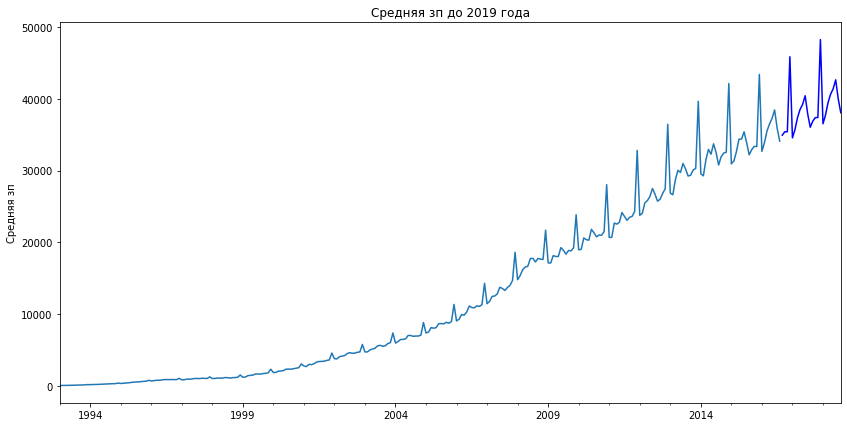

In [73]:
data_1 = data[['wage']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
for_2019 = pd.DataFrame(index=date_list, columns= data_1.columns)
data_1 = pd.concat([data_1, for_2019])
data_1['forecast'] = inv_box_cox(better_model.predict(start=284, end=308), lymbda)

plt.figure(figsize(14,7))
data_1.forecast.plot(color='blue')
plt.ylabel(u'Средняя зп')
plt.title(u'Средняя зп до 2019 года')
data_1.wage.plot()
pylab.show()

Прогноз соотносится с предыдущими показателями. С течением времени ожидается рост средней заработной платы.